# Power traces analysis

This is just a test before applying on the chips. It uses python rather than C.

In [56]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Preprocessing

**Read data from csv file**: get data.

In [2]:
file_path = "../dataset/grafana_data_export.csv"

data = pd.read_csv(file_path, \
                   error_bad_lines=False, warn_bad_lines=False, \
                   sep=';', thousands=',', \
                   dtype={'Series': 'object', 'Value': 'float'}, \
                   parse_dates=['Time'])

display(data.head())
print("Data shape: {0}".format(data.shape))

,Series,Time,Value
0,Black and white printer,2018-10-27 16:44:25,3.31
1,Black and white printer,2018-10-27 16:44:25,3.31
2,Black and white printer,2018-10-27 16:44:26,4.29
3,Black and white printer,2018-10-27 16:44:26,4.29
4,Black and white printer,2018-10-27 16:44:27,3.77


Data shape: (1940080, 3)


In [3]:
data.dtypes

Series            object
Time      datetime64[ns]
Value            float64
dtype: object

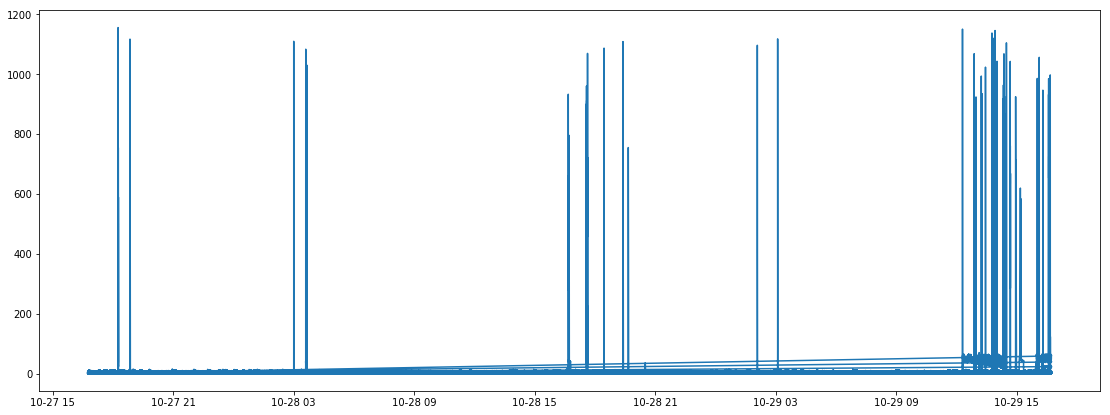

In [4]:
plt.figure(figsize=(19,7))
plt.plot(data['Time'], data['Value'])
plt.show()

**Partitioning**: partition the whole power traces into small traces with a duration of *k* seconds. The label of these small traces is the corresponding value in Series.

In [40]:
def data_partition(time, series, value, k, do_print=False):
    """ Partition data
    
    Args:
        time: (np.array) the 'Time' column in data
        series: (np.array) the 'Series' column in data
        value: (np.array) the 'Value' column in data
        k: (int) indicate the length of small time interval
        do_print: (boolean) print current status or not.
    
    Returns:
        cnt: (int) the number of found valid small traces
        part_time: (np.array) the start time of the corresponding small trace partition
        part_series: (np.array) label of the corresponding trace
        part_value: (2d np.array) the power traces
    """
    n = len(time)
    part_time = np.zeros(n, dtype='datetime64[s]')
    part_series = np.zeros(n, dtype='object')
    part_value =  np.zeros([n, k], dtype='float')
    last_time = time[0] - np.timedelta64(1, 's')
    
    cnt = 0 # count of found valid small traces
    for i in range(n):
        # print current status
        if(do_print and i%50000 == 0):
            print("Current iteration: {0}".format(i))
        # avoid repetition
        if time[i] - last_time == np.timedelta64(0, 'ns'):
            continue
        last_time = time[i]
        
        # get current partition
        cur_label = series[i]
        cur_part = np.full(k, np.nan)
        for j in range(i, n):
            idx = int((time[j] - time[i]) / np.timedelta64(1, 's'))
            if(series[j] != cur_label or idx >= k or idx < 0):
                break
            cur_part[idx] = value[j]
            
        if(len(cur_part) < k): # ignore too short power traces
            continue;
        
        # do interpolation for missing values
        for j in range(len(cur_part)): 
            if(np.isnan(cur_part[j])):
                cur_part[j] = cur_part[j - 1]
        
        # save the partitioned data
        part_time[cnt] = time[i]
        part_series[cnt] = cur_label
        part_value[cnt] = cur_part
        cnt += 1;
    
    return cnt, part_time[:cnt], part_series[:cnt], part_value[:cnt]

In [41]:
k = 10
data_time, data_series, data_value = pd.np.array(data['Time']), pd.np.array(data['Series']), pd.np.array(data['Value'])

cnt, part_time, part_series, part_value = data_partition(data_time, data_series, data_value, k, do_print=True)

Current iteration: 0
Current iteration: 50000
Current iteration: 100000
Current iteration: 150000
Current iteration: 200000
Current iteration: 250000
Current iteration: 300000
Current iteration: 350000
Current iteration: 400000
Current iteration: 450000
Current iteration: 500000
Current iteration: 550000
Current iteration: 600000
Current iteration: 650000
Current iteration: 700000
Current iteration: 750000
Current iteration: 800000
Current iteration: 850000
Current iteration: 900000
Current iteration: 950000
Current iteration: 1000000
Current iteration: 1050000
Current iteration: 1100000
Current iteration: 1150000
Current iteration: 1200000
Current iteration: 1250000
Current iteration: 1300000
Current iteration: 1350000
Current iteration: 1400000
Current iteration: 1450000
Current iteration: 1500000
Current iteration: 1550000
Current iteration: 1600000
Current iteration: 1650000
Current iteration: 1700000
Current iteration: 1750000
Current iteration: 1800000
Current iteration: 1850000


In [53]:
data_part_df = pd.DataFrame([part_time, part_series, part_value])

In [54]:
data_part_df = data_part_df.T
data_part_df.columns = ["time", "series", "partition_values"]

In [55]:
data_part_df.head()

,time,series,partition_values
0,2018-10-27T16:44:25,Black and white printer,"[3.31, 4.29, 3.77, 4.03, 4.03, 2.71, 3.11, 2.3..."
1,2018-10-27T16:44:26,Black and white printer,"[4.29, 3.77, 4.03, 4.03, 2.71, 3.11, 2.36, 2.3..."
2,2018-10-27T16:44:27,Black and white printer,"[3.77, 4.03, 4.03, 2.71, 3.11, 2.36, 2.36, 2.3..."
3,2018-10-27T16:44:28,Black and white printer,"[4.03, 4.03, 2.71, 3.11, 2.36, 2.36, 2.39, 3.0..."
4,2018-10-27T16:44:30,Black and white printer,"[2.71, 3.11, 2.36, 2.36, 2.39, 3.08, 3.69, 3.2..."


**Generate training/testing data set**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    data_part_df[['time', 'partition_values']], 
    data_part_df['series'], 
    test_size=0.33, 
    random_state=59)
print("{0} train + {1} test".format(len(X_train), len(X_test)))

1069689 train + 526863 test
